## Global Alignment Kernel

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

from tslearn.clustering import KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


import matplotlib.pyplot as plt

import yfinance as yfin

Start by analyzing proof of positive defineteness of Alignment Kernel as proposed by authors in Cuturi, M., et al. (2007). *A Kernel for time sereis based on global alignment*, 2007 IEEE International Conference

#### Download test data

In [3]:
# Download data sample
tickers = ["BTC-USD", "ETH-USD", "GOOG", "MSFT", "LINK-USD", "AAPL", "NFLX"]
start_date = "2020-01-01"
end_date = "2022-12-31"

yfin.pdr_override()

fin_data = []
for i in tickers:
    data = pdr.get_data_yahoo(i, start=start_date, end=end_date, interval="1wk")['Close']
    fin_data.append(np.array([[x] for x in data]))

fin_data = np.array(fin_data)

## UNCOMMENT TO DOWNLOAD FULL DATASET
# btc_data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
# eth_data = pdr.get_data_yahoo(tickers[1],  start=start_date, end=end_date, interval = "1wk")
# goog_data = pdr.get_data_yahoo(tickers[2],  start=start_date, end=end_date, interval = "1wk")
# msft_data = pdr.get_data_yahoo(tickers[3],  start=start_date, end=end_date, interval = "1wk")

# Normalize data
X = fin_data
X = TimeSeriesScalerMeanVariance().fit_transform(X)

# Save close data
btc_close = fin_data[0,:,:]
eth_close = fin_data[1,:,:]
goog_close = fin_data[2,:,:]
msft_close = fin_data[3,:,:]
nflx_close = fin_data[6,:,:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


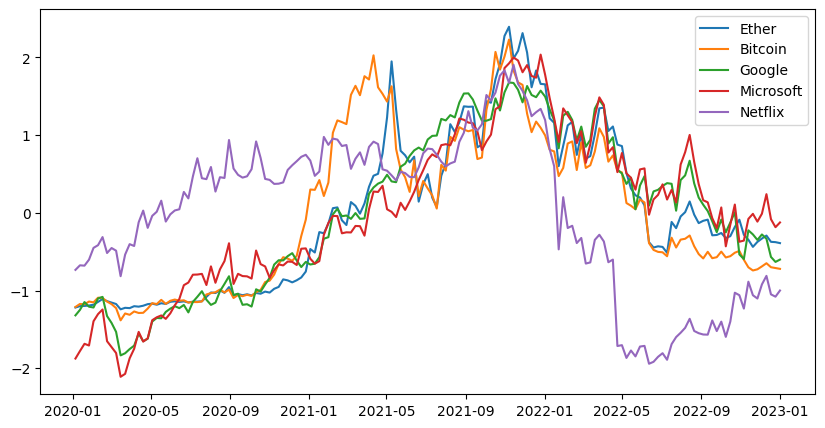

In [4]:
#Visualize time series
%matplotlib inline

btc_normalized_close = X[0,:,:]
eth_normalized_close = X[1,:,:]
goog_normalized_close = X[2,:,:]
msft_normalized_close = X[3,:,:]
nflx_normalized_close = X[6,:,:]

#X = np.array([btc_close.values,eth_close.values, msft_close.values, goog_close.values])


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0], freq='w'), eth_normalized_close, label = 'Ether')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), btc_normalized_close, label = 'Bitcoin')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), goog_normalized_close, label = 'Google')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), msft_normalized_close, label = 'Microsoft')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), nflx_normalized_close, label = 'Netflix')
ax.legend()

In [12]:
seed = 0
np.random.default_rng(seed)

X = fin_data
X = TimeSeriesScalerMeanVariance().fit_transform(X)
print(fin_data.shape, X.shape)

# Check for alignment
# print(X_train.shape, X.shape)

sz = X.shape[1]

n_clusters = 3

gak_km = KernelKMeans(n_clusters=n_clusters,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=False,
                      random_state=seed)
y_pred = gak_km.fit_predict(X)

plt.figure()
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

TypeError: 'numpy.random._generator.Generator' object is not callable

In [6]:
def convert_data_gak(X = X):
    gak = []
    for i in range(X.shape[0]):
        gak.append([float(x) for x in X[i]])
    return np.array(gak)


In [7]:
from tslearn.metrics import gak, sigma_gak

gak_data = convert_data_gak()
sigma = sigma_gak(gak_data)
k_01 = gak(gak_data[4], gak_data[6], sigma=sigma)
print(k_01)

0.39948725444162886


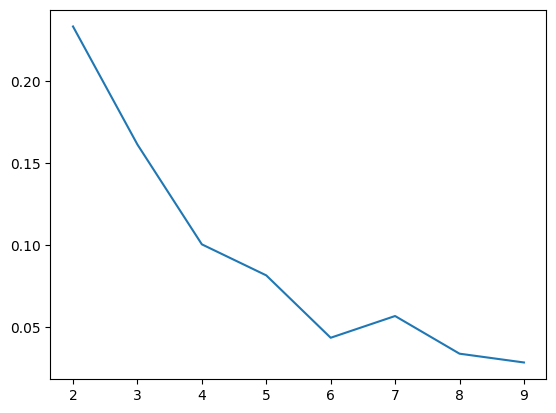

In [8]:
# Construct ELbow Method to finding optimal number of clusters in K-Means

#! the value of sigma needs to be aligned with the one used in the gaussian kernel of Global Alignment Kernel in K-means

final = []
for n_clusters in list(range(2,10)):
    gak_km = KernelKMeans(n_clusters=n_clusters,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=False,
                      random_state=seed)
    y_pred = gak_km.fit_predict(X)
    gak_data = convert_data_gak(X)
    sigma = sigma_gak(gak_data)
    similar_indexes = []
    for i in list(range(n_clusters)):
        similar_indexes.append([v for v,n in enumerate(y_pred) if y_pred[v] == i])
    count = 1
    result = []
    for n in similar_indexes:
        gak_value = 0
        while count < len(n):
            for i in range(len(n)-1):
                for v in list(range(count,len(n))):
                    gak_value += gak(gak_data[i], gak_data[v], sigma=sigma)
                count += 1
        if sum(list(range(len(n)+1))) != 0:
            result.append(gak_value/sum(list(range(len(n)+1))))
        else:
            result.append(gak_value)
    final.append((n_clusters,sum(result)/n_clusters))
index = [i for i,v in final]
value = [v for i,v in final]
plt.plot(index, value)

    

In [9]:
l = [0,1,0,0,0,1,0,2] #y_pred
m = [] #similar indexes
for i in list(range(3)): #n_clusters
    m.append([v for v,n in enumerate(l) if l[v] == i])
print(m)

[[0, 2, 3, 4, 6], [1, 5], [7]]
